<a href="https://colab.research.google.com/github/hrishipoola/GMV_Optimized_Portfolio/blob/main/Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
1. Introduction
2. Install & Import Packages
3. Load & Process Data
4. Component Return, Correlation, & Distribution
5. Naive Portfolio (Equal-Weighted)
<br> Construct
<br> Daily Returns
<br> Cumulative Returns
<br> Covariance Matrix
<br> Expected Returns, Variance, & Volatility
<br> Tail Risk (Historical Drawdown, VaR, CVaR)
6. Portfolio Optimization
<br> Risk-Free Rate
<br> Exponentially Weighted Returns & Sigma
<br> MSR Portfolio
<br> GMV Portfolio
<br> Cumulative Returns
7. Monte Carlo Simulation
8. References






## 1. Introduction

My wife caught the investing bug. She recently put together a portfolio of healthcare, consumer (cyclical and defensive), technology services, and media companies that she'd like to invest in long-term based on their business model / fundamentals, earnings and cash flow outlook, and current (under)valuation: 

- Norton LifeLock (NLOK)
- Keysight (KEYS)
- BioNTech (BNTX)
- Quest Diagnostics (DGX)
- Disney (DIS)
- Kroger (KR)
- Pinduoduo (PDD)
- Peloton (PTON)
- NetEase (NTES)
- Bristol Myers Squibb (BMY)

In this post, I'll walk through how I helped her optimize, that is, find the best weights (allocation) for her investment to maximize risk-adjusted returns based on her risk tolerance. 

We'll first collect price data going back 5 years using the yahoo finance API and take a look at company returns, correlations, and distributions. Before creating an optimal portfolio, we'll construct an equal-weighted (naive) portfolio and understand expected portfolio returns, volatility, and tail risk, including value-at-risk (VaR) and conditional value-at-risk (CVaR) at 95% and 99% confidence. 

We'll then dig further to uncover simple Markowitz-optimized portfolios. To get more optimal weightings, let's first revisit our inputs - expected return and covariance. Since expected returns have fluctuated significantly, particularly over the past year of the pandemic, let's exponentially weight returns to give more weight to more recent returns of the past 6 months. Additionally, the sample covariance we calculated for the equal-weighted portfolio isn't very efficient because it overweights extreme events - even small differences in covariance can have a significant impact on optimal weights. Covariance shrinkage is often used in practice to address this. It combines the sample covariance matrix with a structured estimator, to reduce the effect of erroneous weights. To improve our optimization, let's apply covariance shrinkage using the Ledoit Wolf method to get an efficient covariance. 

We'll create maximum Sharpe Ratio (MSR) and global minimum variance (GMV) portfolios. Since MSR can be inconsistent - optimization is sensitive to expected return, which is difficult to estimate with high confidence - we'll opt for the GMV portfolio. We'll also see how cumulative returns from all of the portfolios we constructed compare to that of the S&P500. Finally, to better understand how our GMV portfolio could perform in the future, we'll run a Monte Carlo simulation with 1,000 simulations to arrive at a parametric VaR and CVaR of simulated future returns. As we'll see, one [caveat](https://www.top1000funds.com/wp-content/uploads/2014/04/Risk-Parity-and-Beyond-From-Asset-Allocation-to-Risk-Allocation-Decisions.pdf) of GMV is that it tends to overweight low-volatility components. To address this, we'll make minor tweaks to the GMV weights to arrive at our final portfolio. 

Future areas to explore:
- Apply robust optimization methods like Black-Litterman
- Incorporate more realistic, time-varying volatility estimates using GARCH models (similar to what we did in prior posts on Moderna, Spotify, and Abbvie [here](https://crawstat.com/2021/02/03/moderna-abbvie-dynamic-covariance/), [here](https://crawstat.com/2021/02/01/spotify-dynamic-conditional-beta/), and [here](https://crawstat.com/2021/02/03/moderna-abbvie-dynamic-covariance/)). 

## 2. Install & Import Packages

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from datetime import datetime, timedelta

import scipy.stats
from scipy.stats import norm, skew, kurtosis
from math import log, sqrt, pi, exp
from numpy.random import normal, seed

!pip install yfinance
!pip install pandas-datareader
!pip install pyfolio
import yfinance as yf 
from pandas_datareader import data as pdr
import pyfolio as pf

sns.set_style("darkgrid") # Set seaborn plot style

In [48]:
!pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import DiscreteAllocation, get_latest_prices
from pypfopt import CLA
from pypfopt.risk_models import CovarianceShrinkage

## 3. Load & Process Data

In [49]:
# Dataframe of adjusted close price 
tickers = ['NLOK','KEYS','BNTX','DGX','DIS','KR','PDD','PTON','NTES','BMY']
start_date = (datetime.today() - timedelta(365*5)).strftime('%Y-%m-%d') # start date five years prior 
end_date = datetime.today().strftime('%Y-%m-%d')

close = pdr.get_data_yahoo(tickers, start=start_date, end=end_date)[['Adj Close']]
close.head()

Attributes Adj Close                         ...                               
Symbols         NLOK   KEYS BNTX        DGX  ... PDD PTON       NTES        BMY
Date                                         ...                               
2016-03-23  9.940686  27.00  NaN  63.376205  ... NaN  NaN  27.037888  54.000332
2016-03-24  9.978018  27.00  NaN  63.050972  ... NaN  NaN  26.800453  54.156250
2016-03-28  9.850027  27.24  NaN  63.602058  ... NaN  NaN  25.969425  54.372795
2016-03-29  9.807362  27.74  NaN  64.577766  ... NaN  NaN  25.757963  55.602848
2016-03-30  9.802032  27.42  NaN  65.282455  ... NaN  NaN  26.457283  55.280426

[5 rows x 10 columns]

In [50]:
# Format 
close = close.droplevel(0, axis=1)
close.reset_index(inplace=True)
close.set_index('Date', inplace=True)
close.index.name = None
close.head()

Symbols,NLOK,KEYS,BNTX,DGX,DIS,KR,PDD,PTON,NTES,BMY
2016-03-23,9.940686,27.00,NaN,63.376205,91.353615,34.098763,NaN,NaN,27.037888,54.000332
2016-03-24,9.978018,27.00,NaN,63.050972,91.721550,34.153191,NaN,NaN,26.800453,54.156250
2016-03-28,9.850027,27.24,NaN,63.602058,92.542328,34.525108,NaN,NaN,25.969425,54.372795
2016-03-29,9.807362,27.74,NaN,64.577766,92.608383,34.497894,NaN,NaN,25.757963,55.602848
2016-03-30,9.802032,27.42,NaN,65.282455,93.315971,34.552319,NaN,NaN,26.457283,55.280426


In [51]:
sectors = dict()
for ticker in tickers:
  sectors[ticker] = (yf.Ticker(ticker)).info['sector']

sectors

{'BMY': 'Healthcare',
 'BNTX': 'Healthcare',
 'DGX': 'Healthcare',
 'DIS': 'Communication Services',
 'KEYS': 'Technology',
 'KR': 'Consumer Defensive',
 'NLOK': 'Technology',
 'NTES': 'Communication Services',
 'PDD': 'Consumer Cyclical',
 'PTON': 'Consumer Cyclical'}

## 4. Component Returns, Correlation, Distribution

### Daily Returns

In [52]:
returns = close.pct_change()
mean_daily_returns = returns.mean()
mean_daily_returns

Symbols
NLOK    0.000857
KEYS    0.001501
BNTX    0.008384
DGX     0.000671
DIS     0.000756
KR      0.000223
PDD     0.003476
PTON    0.004963
NTES    0.001442
BMY     0.000265
dtype: float64

More recently listed companies liked PTON and BNTX have the highest daily returns.

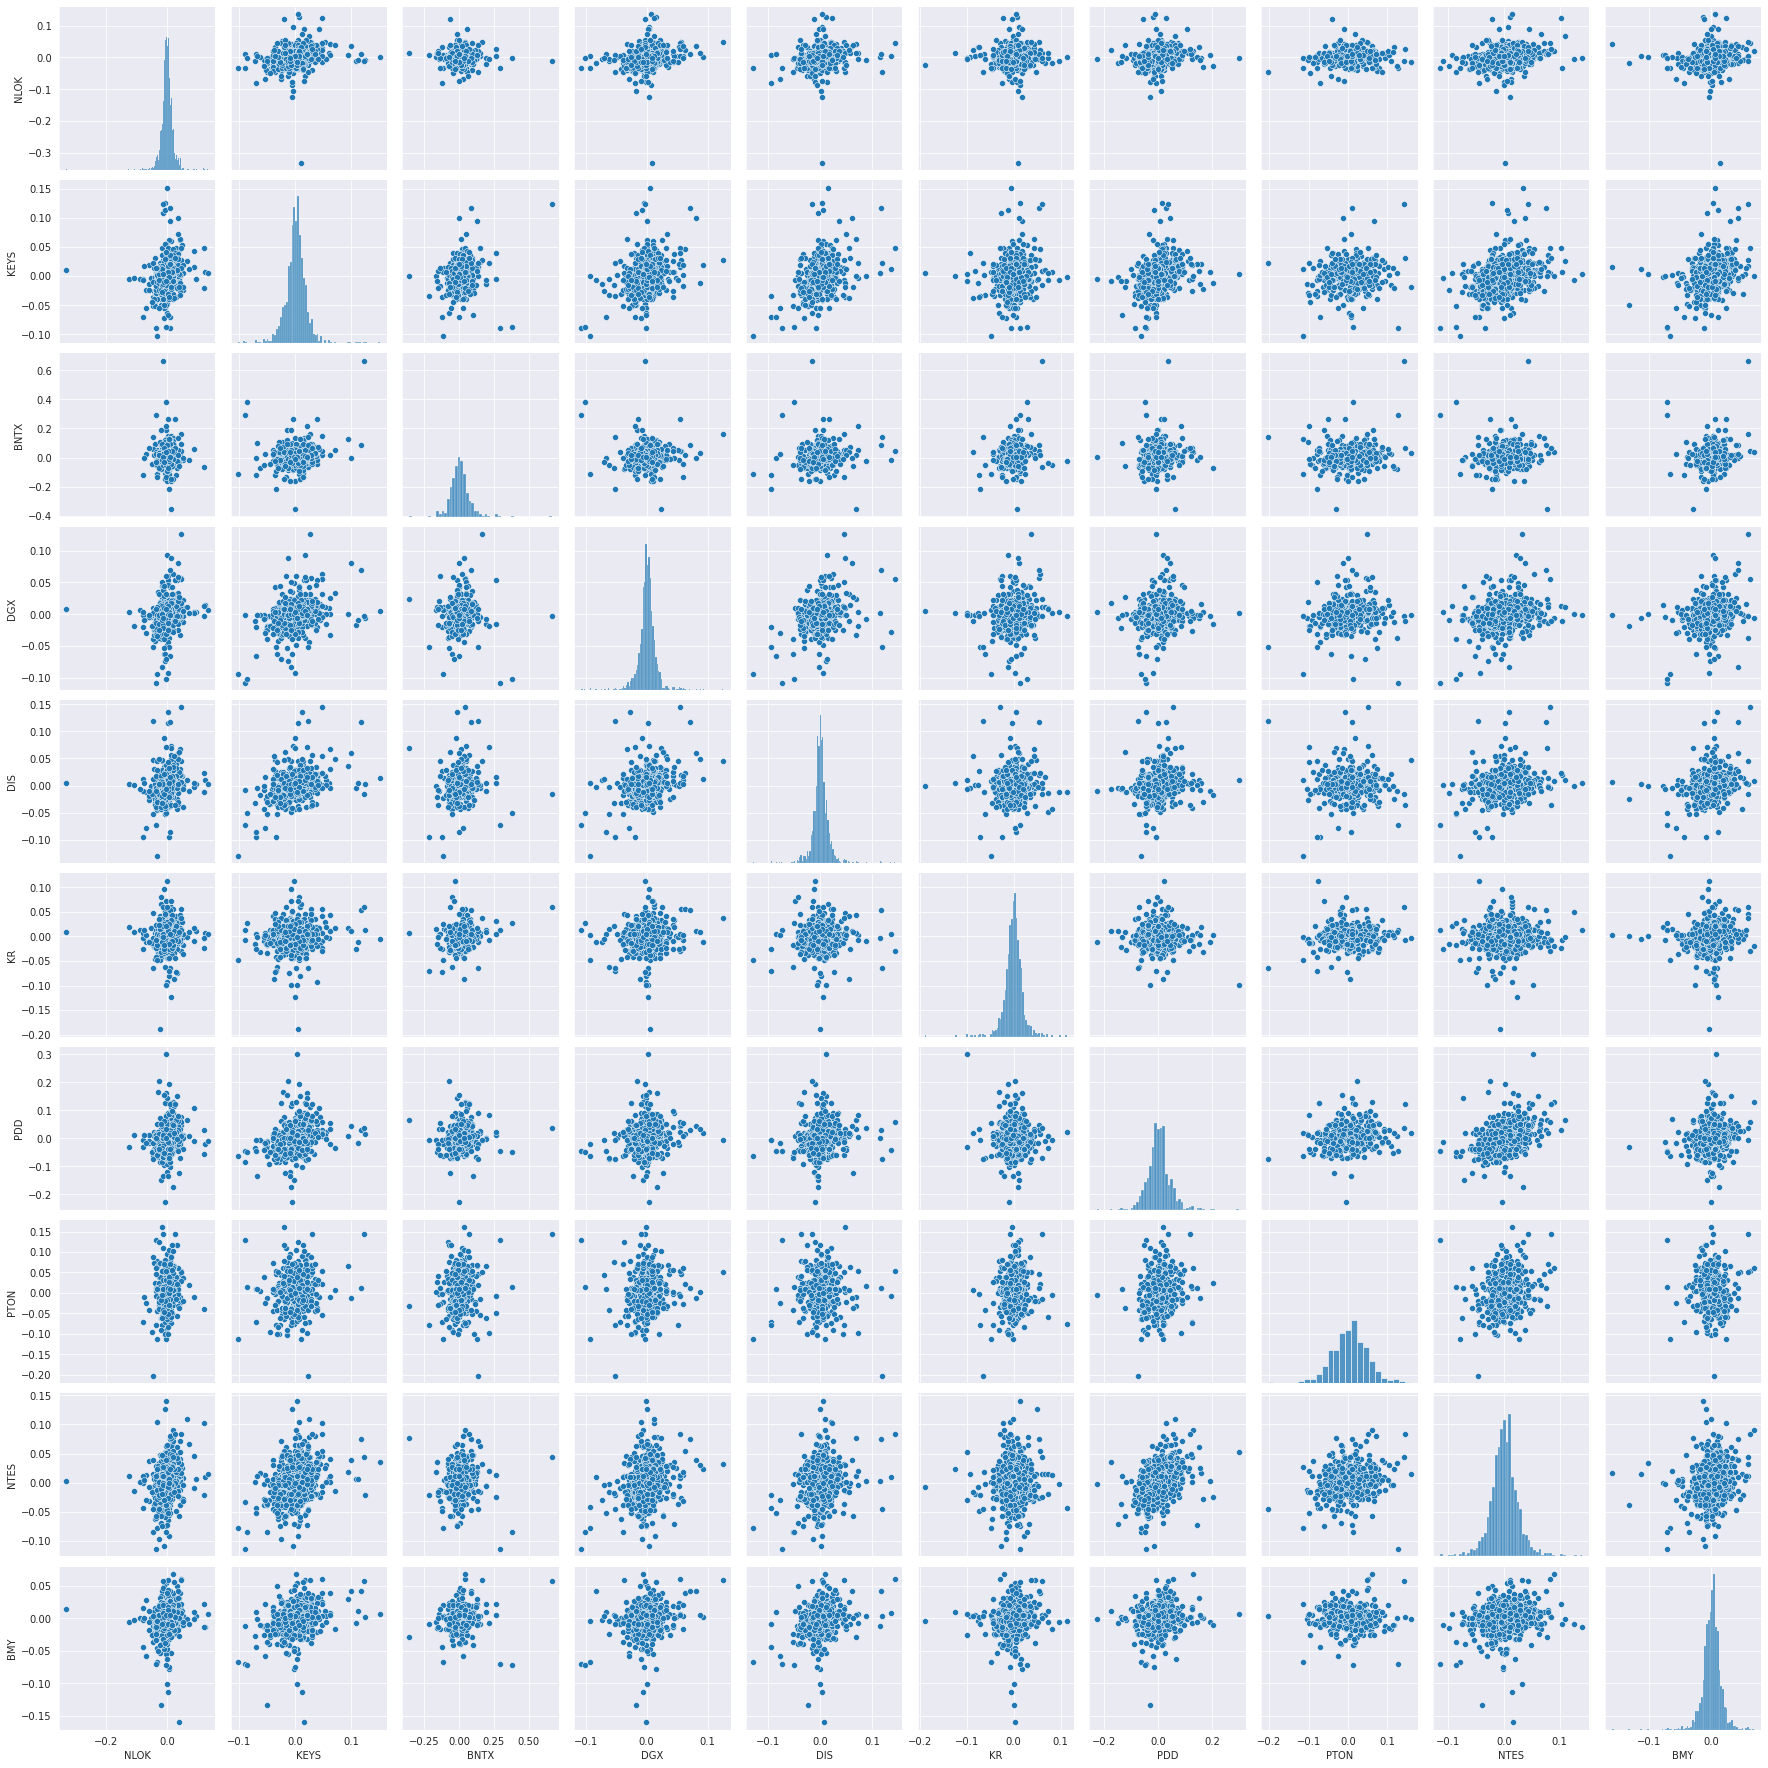

In [53]:
sns.pairplot(returns)

The pairplot gives us a sense of how each component might be correlated and their returns distribution. The scatterplots reveal fairly low correlation between each company. As we'd expected, younger companies like PTON and BNTX have more widely distributed returns. 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

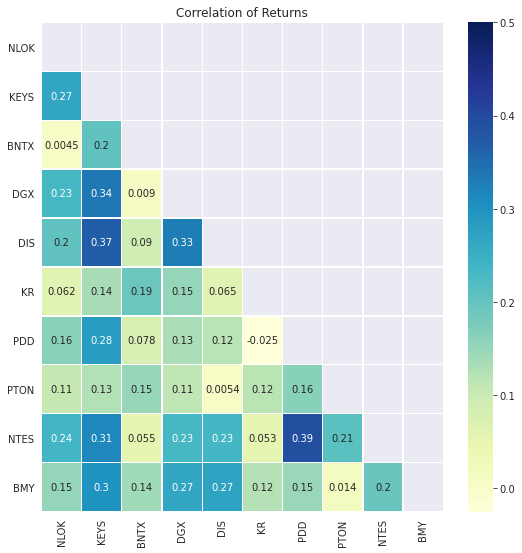

In [54]:
correlations = returns.corr()

plt.figure(figsize=(9,9))
matrix = np.triu(correlations) # mask to only show bottom half of heatmap
sns.heatmap(correlations, annot=True, cmap='YlGnBu', vmax=0.5, linewidths=0.3, annot_kws={"size": 10}, mask=matrix)
plt.title('Correlation of Returns')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

While not reading too much into returns correlation, it would be good to have correlations between returns as close to 0 as possible. The correlation heatmap shows fairly low correlation, with the highest being between the Chinese companies PDD and NTES. Interestingly, KEYS seems to have generally higher correlations than the other companies. 

By plotting distributions of monthly returns, we can more clearly see the differences in component return distributions, especially skew and kurtosis.

Text(0.5, 1.0, 'Distribution of Monthly Return')

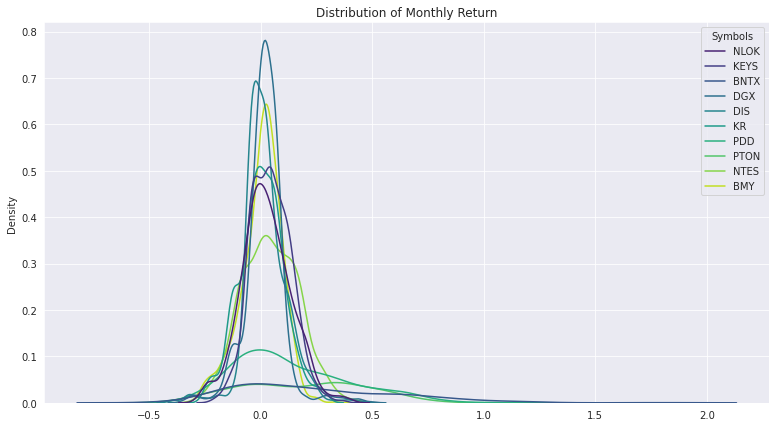

In [55]:
# Plot distribution of monthly return
monthly_return = close.pct_change(30)
plt.figure(figsize=(13,7))
sns.kdeplot(data=monthly_return, palette='viridis')
plt.title('Distribution of Monthly Return')



Notice the much wider (higher volatility) distributions for BNTX and PDD. 

## 5. Naive Portfolio (Equal-Weighted)

### Construct

In [56]:
# Equal-weighted portfolio weights
num_assets = len(tickers)
weights_equal = np.repeat(1/num_assets, num_assets) 
weights_equal

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [57]:
# Portfolio return
portfolio_daily_return = returns.mul(weights_equal, axis=1).sum(axis=1) # dot product
returns['Portfolio'] = portfolio_daily_return
returns.head()

Symbols,NLOK,KEYS,BNTX,DGX,DIS,KR,PDD,PTON,NTES,BMY,Portfolio
2016-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2016-03-24,0.003755,0.000000,NaN,-0.005132,0.004028,0.001596,NaN,NaN,-0.008782,0.002887,-0.000165
2016-03-28,-0.012827,0.008889,NaN,0.008740,0.008949,0.010890,NaN,NaN,-0.031008,0.003999,-0.000237
2016-03-29,-0.004332,0.018355,NaN,0.015341,0.000714,-0.000788,NaN,NaN,-0.008143,0.022623,0.004377
2016-03-30,-0.000543,-0.011536,NaN,0.010912,0.007641,0.001578,NaN,NaN,0.027150,-0.005799,0.002940


### Daily Returns

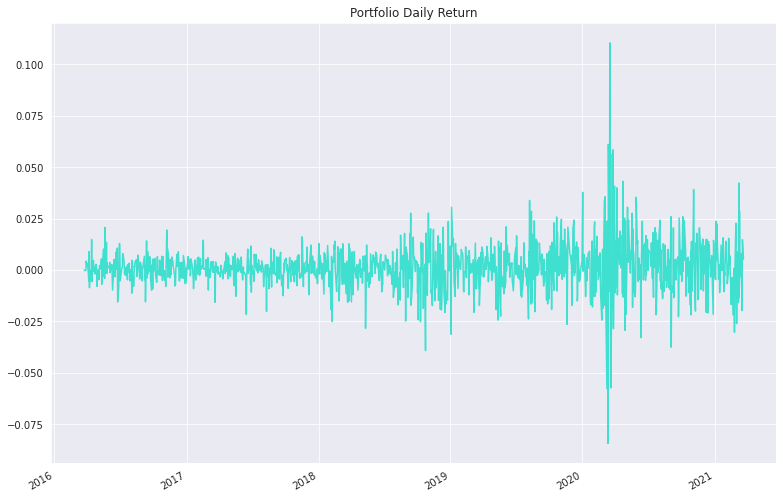

In [58]:
returns['Portfolio'].plot(title='Portfolio Daily Return', color='turquoise', figsize=(13,9))

Visualizing daily returns, we can see dramatic volatility at the start of the pandemic. It also looks like the volatility is structurally higher since then.  

### Distribution

Text(0.5, 1.0, 'Distribution of Portfolio Returns')

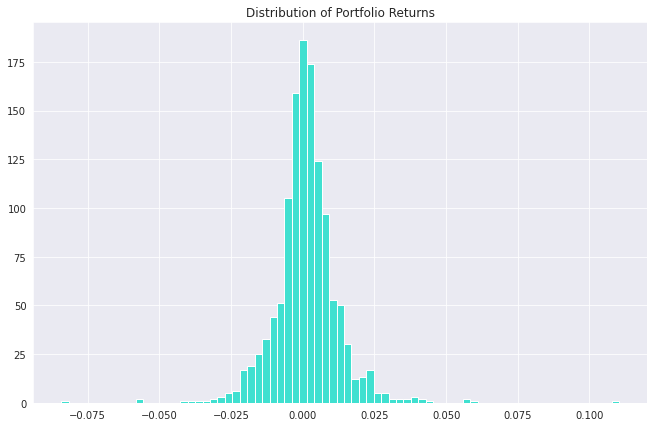

In [59]:
plt.figure(figsize=(11,7))
plt.hist(returns['Portfolio'], bins=75, color='turquoise')
plt.title('Distribution of Portfolio Returns')

The distribution of equal weighted portfolio returns is slightly right-skewed. 

In [60]:
# Average annualized porfolio return
((1 + np.mean(returns['Portfolio']))** 252) - 1

0.33405068152574513

In [61]:
means = returns.mean() 
std_devs = returns.std() 
skews = returns.skew()
kurtosis = returns.kurtosis()

stats = {'Mean' : means, 'Std Dev':std_devs, 'Skew':skews, 'Kurtosis': kurtosis}
pd.DataFrame.from_dict(stats)

,Mean,Std Dev,Skew,Kurtosis
Symbols,,,,
NLOK,0.000857,0.021782,-2.483684,48.079588
KEYS,0.001501,0.020300,0.741319,8.674553
BNTX,0.008384,0.077467,2.013683,17.003344
DGX,0.000671,0.016051,-0.161086,11.943054
DIS,0.000756,0.017756,0.969531,15.438056
KR,0.000223,0.019327,-1.045026,12.497247
PDD,0.003476,0.045720,0.596749,5.303162
PTON,0.004963,0.046529,-0.030447,1.202344
NTES,0.001442,0.025123,0.216953,3.203978


Looking at the distributions' features, the equal-weighted portfolio is positively skewed and leptokurtic (kurtosis > 3), meaning more and more extreme outliers on either end than a normal distribution. In fact, it's kurtosis at 12 is quite high, meaning its overall risk comes from outliers. The porfolio also contains a mix of negative and postive skew component return distributions. 

### Cumulative Returns

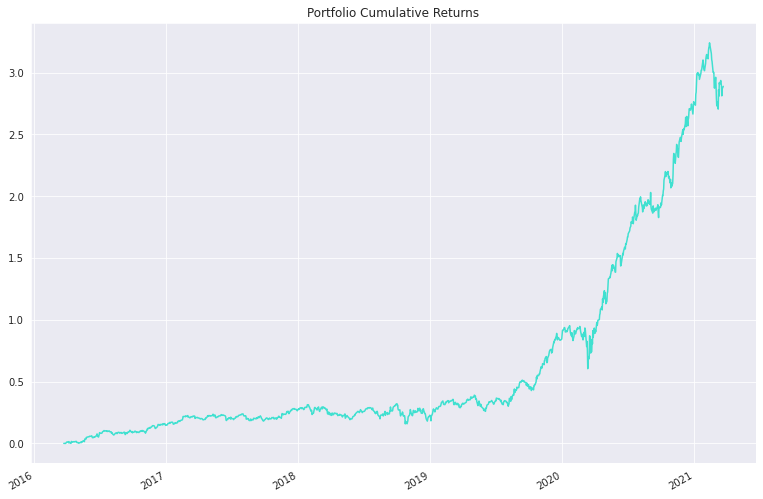

In [62]:
cumulative_returns = ((1 + returns).cumprod()-1)
cumulative_returns['Portfolio'].plot(title='Portfolio Cumulative Returns', color='turquoise', figsize=(13,9))

### Covariance Matrix

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

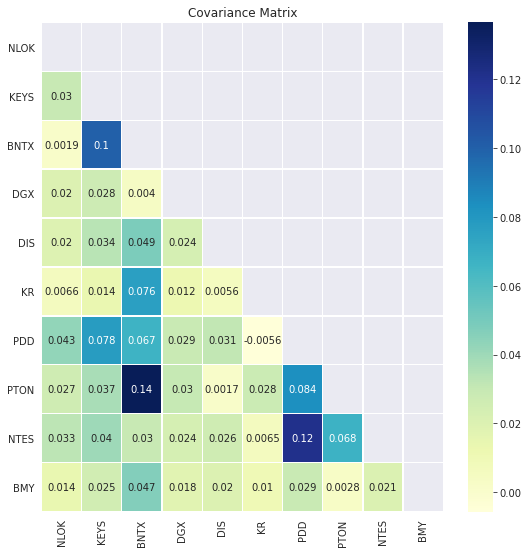

In [63]:
# Covariance matrix 
returns = close.pct_change()
trading_days = 252
cov_matrix = (returns.cov()) * trading_days

plt.figure(figsize=(9,9))
matrix = np.triu(cov_matrix) # mask to only show bottom half of heatmap
sns.heatmap(cov_matrix, annot=True, cmap='YlGnBu', linewidths=0.3, annot_kws={"size": 10}, mask=matrix)
plt.title('Covariance Matrix')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

### Expected Return, Volatility, & Variance

In [64]:
# Portfolio variance
portfolio_variance = np.dot(weights_equal.T, np.dot(cov_matrix, weights_equal))

# Portfolio volatility (std. dev)
portfolio_std_dev = np.sqrt(portfolio_variance)

# Portfolio annualized expected return
portfolio_annualized_return = np.sum(returns.mean() * weights_equal * trading_days)

print('Expected Annual Return: '+ str(np.round(portfolio_annualized_return, 3) * 100) + '%')
print('Annual Volataility: '+ str(np.round(portfolio_std_dev, 4) * 100) + '%')
print('Annual Variance: '+ str(np.round(portfolio_variance, 3) * 100) + '%')

Expected Annual Return: 56.8%
Annual Volataility: 25.230000000000004%
Annual Variance: 6.4%


### Tail Risk

#### Historical Drawdown

Percentage loss from highest cumulative historical point. 

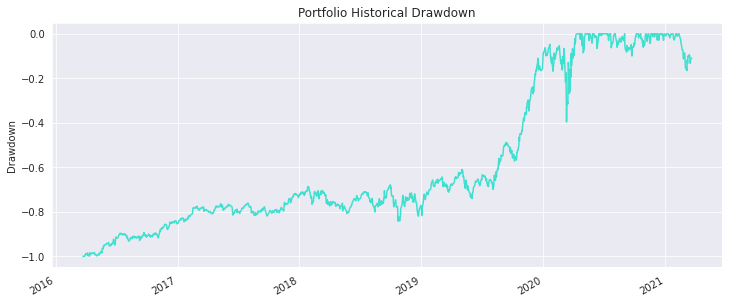

In [65]:
running_max = np.maximum.accumulate(cumulative_returns)
running_max[running_max < 1] = 1 # only interested in losses 
drawdown = (cumulative_returns) / running_max - 1
drawdown['Portfolio'].plot(figsize=(12,5), ylabel='Drawdown', title='Portfolio Historical Drawdown', color='turquoise')

There was a drowdown of 40% at the start of the pandemic. Interestingly, the portfolio has had a modest drawdown in the first few months of this year. 

### Value at Risk (VaR)

Threshold with given confidence level that losses will not historically exceed certain level. 

In [66]:
var_95 = np.percentile(portfolio_daily_return, 5)
var_95

-0.016433825820028076

Our Var(95) of -0.0164 means that in the worst 5% of cases, losses will not exceed 1.64% or that we can be 95% certain that losses will not exceed 1.64% in a given day. 

### Conditional Value at Risk (CVaR) (Expected Shortfall)

Expected losses in worst 1-x% scenarios.


In [67]:
cvar_95 = portfolio_daily_return[portfolio_daily_return <= var_95].mean()
cvar_95

-0.024198108606905678

Our cvar(95) of -0.0242 means that in the worst 5% of cases losses were on average 2.42% historically. 

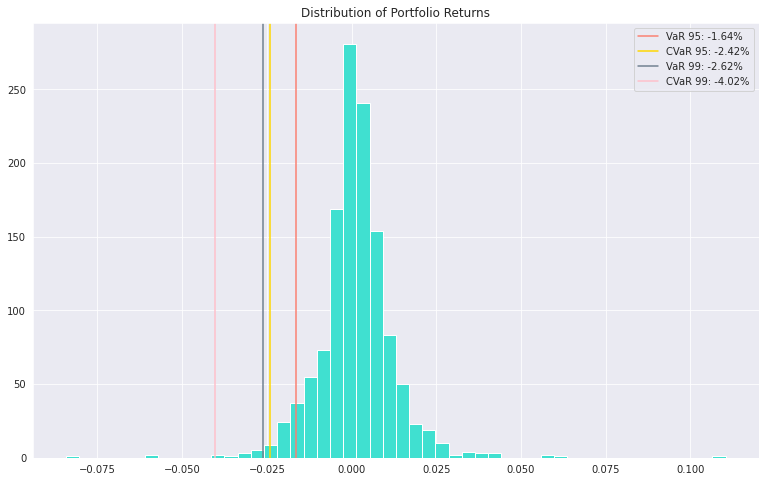

In [68]:
# Plot var - let's also include var(99) and cvar(99)

var_99 = np.percentile(portfolio_daily_return, 1)
cvar_99 = portfolio_daily_return[portfolio_daily_return <= var_99].mean()

sorted_returns = sorted(portfolio_daily_return)
plt.figure(figsize=(13,8))
plt.hist(sorted_returns, bins=50, color='turquoise')
plt.title('Distribution of Portfolio Returns')
plt.axvline(x=var_95, color='salmon', linestyle='-', label='VaR 95: {0:.2f}%'.format(var_95*100))
plt.axvline(x=cvar_95, color='gold', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95*100))
plt.axvline(x=var_99, color='slategray', linestyle='-', label='VaR 99: {0:.2f}%'.format(var_99*100))
plt.axvline(x=cvar_99, color='pink', linestyle='-', label='CVaR 99: {0:.2f}%'.format(cvar_99*100))
plt.legend()

### Parametric VaR

In [69]:
mu = np.mean(portfolio_daily_return)
std = np.std(portfolio_daily_return)
confidence_level = 0.05
parametric_var_95 = norm.ppf(confidence_level, mu, std)
parametric_var_95

-0.017544449831466344

### VaR Scaled by Time

Text(0, 0.5, 'VaR 95')

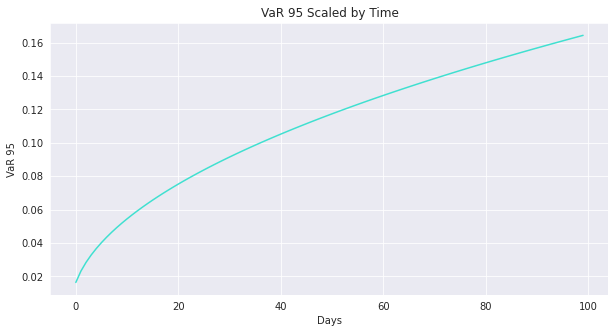

In [70]:
# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(0, 100): 
    forecasted_values[i, 0] = i 
    forecasted_values[i, 1] = var_95 * np.sqrt(i+1) * -1

forecasted_values = pd.DataFrame(forecasted_values)
plt.figure(figsize=(10,5))
plt.plot(forecasted_values[0], forecasted_values[1], color='turquoise')
plt.title('VaR 95 Scaled by Time')
plt.xlabel('Days')
plt.ylabel('VaR 95')


## 6. Portfolio Optimization

### Risk-Free Rate

In [71]:
# For risk free rate, we'll use the latest 10-year U.S. Treasury Yield '^TNX'
today = datetime.now()
r = (pdr.get_data_yahoo('^TNX')['Adj Close'].iloc[-1]) / 100
r

0.016889998912811278

### Exponentially Weighted Returns




Because the last year has been quite volatile, let's weight returns from the past half year of trading days (126 days) more. 

In [72]:
# Exponentially weighted moving average (set the lookback window span to the number of trading days in half a year, 126)
mu_exp_weighted = expected_returns.ema_historical_return(close, span=126, frequency=252)

### Covariance Shrinkage

The sample covariance we calculated earlier isn't very efficient because extreme events are overweighted - even small differences in covariance managed by covariance shrinkage can have a significant impact on optimal weights. 

Covariance shrinkage is often used in practice to address this. It combines the sample covariance matrix with a structured estimator, to reduce the effect of erroneous weights. To improve our optimization, let's apply covariance shrinkage using the ledoit wolf method to get an efficient covariance. 

In [73]:
efficient_cov = CovarianceShrinkage(close).ledoit_wolf()

### Max Sharpe Ratio (MSR) Portfolio

In [74]:
ef = EfficientFrontier(mu_exp_weighted, efficient_cov)

In [75]:
raw_weights_msr = ef.max_sharpe()
weights_msr = ef.clean_weights()
weights_msr

OrderedDict([('NLOK', 0.0),
             ('KEYS', 0.0),
             ('BNTX', 0.12363),
             ('DGX', 0.0),
             ('DIS', 0.63744),
             ('KR', 0.14131),
             ('PDD', 0.00484),
             ('PTON', 0.0),
             ('NTES', 0.09278),
             ('BMY', 0.0)])

In [76]:
ef.portfolio_performance(verbose=True, risk_free_rate = r)

Expected annual return: 97.5%
Annual volatility: 22.8%
Sharpe Ratio: 4.18


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:407: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


(0.974676124521237, 0.2284680140074769, 4.1785986045731285)

In [77]:
latest_prices = get_latest_prices(close)
da = DiscreteAllocation(weights_msr, latest_prices, total_portfolio_value=50000)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation: {'BNTX': 57, 'DIS': 164, 'KR': 198, 'PDD': 2, 'NTES': 42}
Funds remaining: $3.64


In [78]:
pd.DataFrame.from_dict(allocation, orient='index', columns=['Shares'])

,Shares
BNTX,57
DIS,164
KR,198
PDD,2
NTES,42


### Global Minimum Variance (GMV) Portfolio

Since MSR can be inconsistent - optimization is sensitive to expected return, which is difficult to estimate with high confidence - we'll opt for the portfolio with global minimum variance (GMV).

In [79]:
ef = EfficientFrontier(mu_exp_weighted, efficient_cov)

In [80]:
# Min volatility
raw_weights_gmv = ef.min_volatility()
weights_gmv = ef.clean_weights()
weights_gmv

OrderedDict([('NLOK', 0.10088),
             ('KEYS', 0.02718),
             ('BNTX', 0.02605),
             ('DGX', 0.16116),
             ('DIS', 0.14382),
             ('KR', 0.17888),
             ('PDD', 0.03793),
             ('PTON', 0.11184),
             ('NTES', 0.0315),
             ('BMY', 0.18075)])

The allocations for GMV are quite different from MSR. One [caveat](https://www.top1000funds.com/wp-content/uploads/2014/04/Risk-Parity-and-Beyond-From-Asset-Allocation-to-Risk-Allocation-Decisions.pdf) of GMV is that it tends to overweight low-volatility components. 

It looks like the GMV overweights some of the lower volatility components like BMY, DIS, KR, and DGX and underweight higher volatility companies like KEYS, BNTX, PDD, and NTES. Taking this into account, we could us the GMV as a starting point and tweak it to reallocate a bit. 

In [81]:
ef.portfolio_performance(verbose=True, risk_free_rate = r)

Expected annual return: 41.2%
Annual volatility: 15.6%
Sharpe Ratio: 2.53


(0.41223243095802015, 0.15648106800311107, 2.526455353930412)

In [82]:
latest_prices = get_latest_prices(close)
da = DiscreteAllocation(weights_gmv, latest_prices, total_portfolio_value=50000)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation: {'NLOK': 236, 'KEYS': 10, 'BNTX': 12, 'DGX': 64, 'DIS': 37, 'KR': 252, 'PDD': 14, 'PTON': 51, 'NTES': 14, 'BMY': 144}
Funds remaining: $8.74


In [83]:
pd.DataFrame.from_dict(allocation, orient='index', columns=['Shares'])

,Shares
NLOK,236
KEYS,10
BNTX,12
DGX,64
DIS,37
KR,252
PDD,14
PTON,51
NTES,14
BMY,144




We can actually plot the efficient frontier using the constrained line algorithm (CLA) class in the pypfopt library.  

Text(0, 0.5, 'Expected Return')

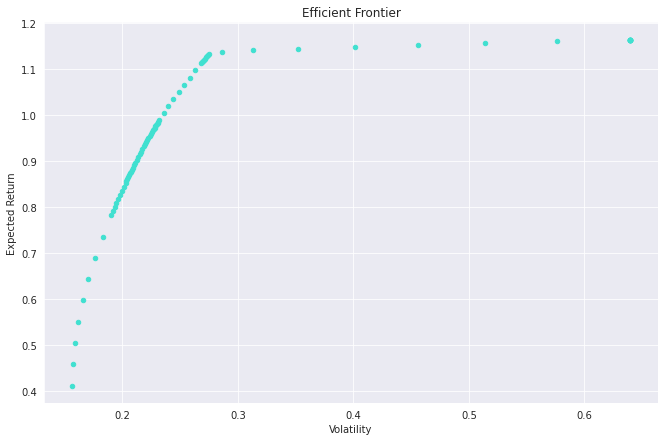

In [84]:
cla = CLA(mu_exp_weighted, efficient_cov)
min_variance_weights = cla.min_volatility() 
(returns, volatility, weights) = cla.efficient_frontier()

plt.figure(figsize=(11,7))
plt.scatter(volatility, returns, s=20, c='turquoise')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')

### Cumulative Returns

In [85]:
returns = close.pct_change()
portfolio_returns_equal = returns.mul(weights_equal, axis=1).sum(axis=1)
portfolio_returns_msr = returns.mul(np.array(list(weights_msr.values())), axis=1).sum(axis=1) # for weights, converted ordered dict into array
portfolio_returns_gmv = returns.mul(np.array(list(weights_gmv.values())), axis=1).sum(axis=1) # for weights, converted ordered dict into array
returns['Portfolio_Equal'] = portfolio_returns_equal
returns['Portfolio_MSR'] = portfolio_returns_msr
returns['Portfolio_GMV'] = portfolio_returns_gmv
returns.head()

Symbols,NLOK,KEYS,BNTX,DGX,DIS,KR,PDD,PTON,NTES,BMY,Portfolio_Equal,Portfolio_MSR,Portfolio_GMV
2016-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2016-03-24,0.003755,0.000000,NaN,-0.005132,0.004028,0.001596,NaN,NaN,-0.008782,0.002887,-0.000165,0.001978,0.000662
2016-03-28,-0.012827,0.008889,NaN,0.008740,0.008949,0.010890,NaN,NaN,-0.031008,0.003999,-0.000237,0.004366,0.003337
2016-03-29,-0.004332,0.018355,NaN,0.015341,0.000714,-0.000788,NaN,NaN,-0.008143,0.022623,0.004377,-0.000412,0.006328
2016-03-30,-0.000543,-0.011536,NaN,0.010912,0.007641,0.001578,NaN,NaN,0.027150,-0.005799,0.002940,0.007612,0.002578


In [86]:
# Add in S&P500 daily returns
sp500 = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)[['Adj Close']]
sp500.rename(columns={'Adj Close':'S&P500'}, inplace=True)
sp500_returns = sp500.pct_change()
returns = pd.concat([returns, sp500_returns], axis=1)
returns.head()

,NLOK,KEYS,BNTX,DGX,DIS,KR,PDD,PTON,NTES,BMY,Portfolio_Equal,Portfolio_MSR,Portfolio_GMV,S&P500
2016-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
2016-03-24,0.003755,0.000000,NaN,-0.005132,0.004028,0.001596,NaN,NaN,-0.008782,0.002887,-0.000165,0.001978,0.000662,-0.000378
2016-03-28,-0.012827,0.008889,NaN,0.008740,0.008949,0.010890,NaN,NaN,-0.031008,0.003999,-0.000237,0.004366,0.003337,0.000545
2016-03-29,-0.004332,0.018355,NaN,0.015341,0.000714,-0.000788,NaN,NaN,-0.008143,0.022623,0.004377,-0.000412,0.006328,0.008817
2016-03-30,-0.000543,-0.011536,NaN,0.010912,0.007641,0.001578,NaN,NaN,0.027150,-0.005799,0.002940,0.007612,0.002578,0.004350


Text(0.5, 1.0, 'Portfolio Cumulative Return')

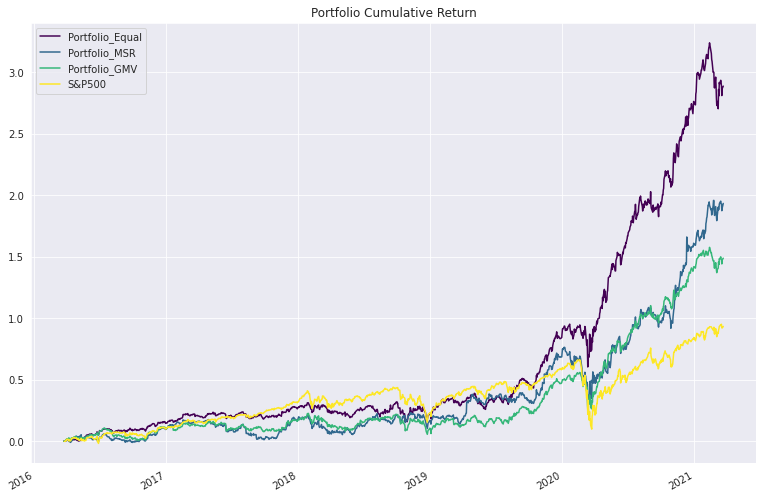

In [87]:
cumulative_returns = ((1 + returns).cumprod()-1)
cumulative_returns[['Portfolio_Equal','Portfolio_MSR','Portfolio_GMV','S&P500']].plot(figsize=(13,9), cmap='viridis')
plt.title('Portfolio Cumulative Return')

## 7. Monte Carlo Simulation

In [88]:
returns = close.pct_change()
portfolio_daily_return = returns.mul(np.array(list(weights_gmv.values())), axis=1).sum(axis=1) # dot product

mu = np.mean(portfolio_daily_return)
volatility = np.std(portfolio_daily_return)

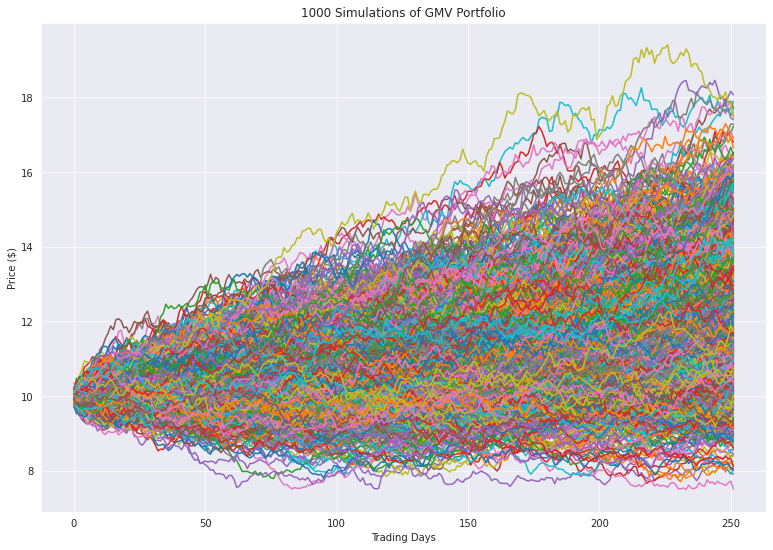

In [89]:
seed(1124)
start_price = 10
trading_days = 252
sim_returns = []
plt.figure(figsize=(13,9))

for i in range(1000):

    # Generate random returns
    random_returns = np.random.normal(mu, volatility, trading_days)
    sim_returns.append(random_returns)
    
    # Monte carlo paths
    forecasted_values = start_price * (random_returns + 1).cumprod()
    
    # Plot
    plt.plot(range(trading_days), forecasted_values)
    plt.title('1000 Simulations of GMV Portfolio')
    plt.xlabel('Trading Days')
    plt.ylabel('Price ($)')

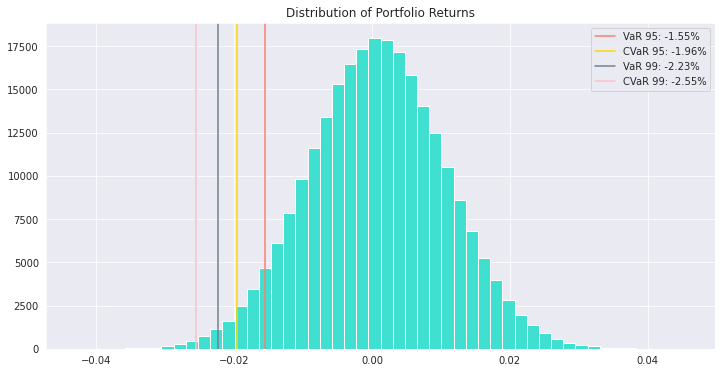

In [90]:
sim_returns = np.concatenate(sim_returns).ravel() # flatten list of arrays into single array 

# Plot var - let's also include var(99) and cvar(99)
var_95 = np.percentile(sim_returns, 5)
cvar_95 = sim_returns[sim_returns <= var_95].mean()
var_99 = np.percentile(sim_returns, 1)
cvar_99 = sim_returns[sim_returns <= var_99].mean()

sorted_returns = sorted(sim_returns)
plt.figure(figsize=(12,6))
plt.hist(sorted_returns, bins=50, color='turquoise')
plt.title('Distribution of Portfolio Returns')
plt.axvline(x=var_95, color='salmon', linestyle='-', label='VaR 95: {0:.2f}%'.format(var_95*100))
plt.axvline(x=cvar_95, color='gold', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95*100))
plt.axvline(x=var_99, color='slategray', linestyle='-', label='VaR 99: {0:.2f}%'.format(var_99*100))
plt.axvline(x=cvar_99, color='pink', linestyle='-', label='CVaR 99: {0:.2f}%'.format(cvar_99*100))
plt.legend()

Based on the simulation of future returns: 

- Var(99) of -0.0223 means that in the worst 1% of cases, losses will not exceed 2.23% or that we can be 99% certain that losses will not exceed 2.26% in a given day. 

- CVaR(99) of -0.0255 means that in the worst 1% of cases losses will be on average 2.55%. 

Given that GMV overweights some of the lower volatility components like BMY, DIS, KR, and DGX and underweights higher volatility companies like KEYS, BNTX, PDD, and NTES, I made some minor tweaks to arrive at the following optimal weights:

- NLOK: 0.1
- KEYS: 0.05
- BNTX: 0.05
- DGX: 0.15
- DIS: 0.15
- KR: 0.15
- PDD: 0.05
- PTON: 0.1
- NTES: 0.05
- BMY: 0.15




 

## 8. References

https://learn.datacamp.com/skill-tracks/applied-finance-in-python

https://github.com/robertmartin8/PyPortfolioOpt

https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html

https://en.wikipedia.org/wiki/Modern_portfolio_theoryg

https://risk.edhec.edu/sites/risk/files/towards-design-better-equity-benchmarks.pdf

https://link.springer.com/article/10.1007/s10898-019-00859-x

https://www.kiplinger.com/investing/stocks/601959/15-best-value-stocks-to-buy-for-2021